In [1]:
!pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/8a/6a/19e9fe04fca059ccf770861c7d5721ab4c2aebc539889e97c7977528a53b/pip-24.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [2]:
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp

In [3]:
!pip install -q git+https://github.com/ott-jax/ott@main
!pip install path.py

In [4]:
TF_CPP_MIN_LOG_LEVEL=0


import numpy as np
import numpy
import time
import timeit

import math
import random
import os
import scipy.spatial.distance
from scipy.stats import special_ortho_group


from jax.example_libraries import optimizers as jax_opt


import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1
import optax

import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

from sklearn.datasets import make_blobs
from path import Path

In [5]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces



class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))


    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))

        sampled_faces = (random.choices(faces,
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))

        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))

        return sampled_points


class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

class RandRotation(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        rot_matrix = special_ortho_group.rvs(3)
        diag_matrix = np.diag(np.random.uniform(low=1, high=3, size=3))
        matrix = rot_matrix.dot(diag_matrix)

        rot_pointcloud = pointcloud @ matrix #matrix.dot(pointcloud.T).T
        return  rot_pointcloud, matrix

class RandomNoise(object):
    def __call__(self, pointcloud, noise_level):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0,noise_level, (pointcloud.shape))

        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud


In [6]:


@jax.jit
def dCdx(x, y):
  # if sqEuclidean
  # each row calculates dC_k/dx_k

  #return 2*(x-y.transpose())
  return 2 * (x[:, None, :] - y[None, :, :]) # M X N X d

@jax.jit
def dOTdx(ot):
  x = ot.geom.x
  y = ot.geom.y
  dCk_dxk =  dCdx(x,y)
  P = ot.matrix
  grad = jnp.sum(dCk_dxk * P[:,:,None], axis=1)
  return grad # M X d




@jax.jit
def LHS_matrix(ot): #
  a = ot.a # size of M
  b = ot.b # size of N
  P = ot.matrix # M by N
  a_P = jnp.sum(P, axis=1)
  b_P = jnp.sum(P, axis=0)

  a_diag = jnp.diag(a_P)  # N by N
  b_diag = jnp.diag(b_P)  # M by M
  PT     = jnp.transpose(P)

  H1 = jnp.concatenate([a_diag, P], axis = 1) # M by (M+N)
  H2 = jnp.concatenate([PT, b_diag], axis = 1) # N by (M+N)
  H = jnp.concatenate([H1, H2], axis=0) # (M+N) by (M+N)

  return H




@jax.jit
def d2Cdx2(x, y):
  # if sqEuclidean
  # the second derivative is 2
  return 2


@jax.jit
def RHS(ot):
  x = ot.geom.x
  y = ot.geom.y
  dCk_dxk =  dCdx(x,y)
  P = ot.matrix
  b_g = jnp.transpose(dCk_dxk * P[:,:,None], [1,0,2]) # N by M by d

  b_g_col = jnp.sum(b_g, axis=0) # M by D

  M, D = b_g_col.shape
  b_f  = jnp.zeros((M, M, D))
  indices = (jnp.arange(M), jnp.arange(M))
  b_f = b_f.at[indices[0], indices[1], :].set(b_g_col) # M by M by d

  b = jnp.concatenate([b_f, b_g], axis=0) # (M+N) X M X d
  return b

@jax.jit
def Sinkhorn_Hessian(ot,svd_thr=1e-10):
  epsilon = ot.geom.epsilon
  H = LHS_matrix(ot)
  nm = H.shape[0]
  R = RHS(ot)
  m = R.shape[1]

  #R_reshape = jnp.reshape(R, [nm, m*dim])
  #HdagR_reshape = jnp.linalg.lstsq(H, R_reshape, svd_thr)[0]
  #HdagR = jnp.reshape(HdagR_reshape, [nm,m,dim])
  #Hessian_1 = jnp.einsum('skd, sjt->kdjt', R, HdagR)/epsilon

  eigenvalues, eigenvectors = jnp.linalg.eigh(H)
  eigenvalues_sqrt_inv = jnp.where(eigenvalues>svd_thr, 1/jnp.sqrt(eigenvalues), 0)
  Hsqrt = eigenvectors * eigenvalues_sqrt_inv[jnp.newaxis, :] # (M+N) by r


  bHsqrt  = jnp.einsum('ikd, is ->ksd ', R, Hsqrt)  #
  Hessian_1 = jnp.einsum('ksd, jst->kdjt', bHsqrt, bHsqrt)/epsilon

  # second part
  x = ot.geom.x
  y = ot.geom.y
  P = ot.matrix
  dCk_dxk = dCdx(x, y)   # M by N by D
  d2Ck_dx2k= d2Cdx2(x, y)
  M, N, D = dCk_dxk.shape

  weighted_C = - dCk_dxk/epsilon * P[:, :, None]
  Hessian_2_part = jnp.einsum('kjs,kjt->kst', weighted_C, dCk_dxk) # M-by-D-by-D
  Hessian_3_diag = jnp.sum(d2Ck_dx2k*P,axis=1)

  identity_matrix = jnp.eye(D)
  expanded_Hessian_3_diag = Hessian_3_diag[:, None, None]
  G = Hessian_2_part + expanded_Hessian_3_diag * identity_matrix

  Hessian_2 = jnp.zeros((M, D, M, D))
  indices = jnp.arange(M)
  Hessian_2 = Hessian_2.at[indices, :, indices, :].set(G)


  Hessian = Hessian_1 + Hessian_2

  return Hessian




In [7]:


@jax.jit
def solve_ott( y_pred, y_jx, mu, nv, 𝜀, threshold):
    geom = pointcloud.PointCloud( y_pred,y_jx, epsilon=𝜀)
    prob = linear_problem.LinearProblem(geom, a=mu, b=nv)
    solver = sinkhorn.Sinkhorn(
        threshold=threshold,  max_iterations=100000,
    )
    out = solver(prob)
    return out



@jax.jit
def loss_value(x_jx, y_jx, mu, nv, 𝜀, threshold, params):
    y_pred      = x_jx @ params
    OT          = solve_ott(y_pred,y_jx, mu, nv, 𝜀, threshold)
    value       = OT.reg_ot_cost
    return value

@jax.jit
def value_and_grad_OTT(x_jx, y_jx, mu, nv, 𝜀, threshold, params):
    y_pred      = x_jx @ params
    OT          = solve_ott(y_pred,y_jx, mu, nv, 𝜀, threshold)
    value       = OT.reg_ot_cost
    grads       = x_jx.T@dOTdx(OT)
    return value, grads, OT

@jax.jit
def value_and_grad_and_hess(x_jx, y_jx, mu, nv, 𝜀, threshold, params):
    y_pred      = x_jx @ params
    OT          = solve_ott(y_pred, y_jx, mu, nv, 𝜀, threshold)
    value       = OT.reg_ot_cost
    grads       = x_jx.T@dOTdx(OT)

    Hess        = Sinkhorn_Hessian(OT)
    x_Hess = jnp.tensordot(x_jx, Hess, axes=((0),(0)))
    hess_w = jnp.tensordot(x_Hess, x_jx,axes=((2),(0))).transpose([0,1,3,2])
    dw = jnp.linalg.tensorsolve(hess_w, grads)

    return value, grads, dw



## SGD version
@jax.jit
def value_and_grad_sgd_OTT(x_jx, y_jx, nv,  𝜀, threshold, params, indices):
    n = x_jx.shape[0]
    x = x_jx[indices]
    n_s = len(indices)
    y_pred      = x @ params
    mu          = jnp.ones((n_s,)) / n_s
    OT          = solve_ott(y_pred, y_jx, mu, nv, 𝜀, threshold)
    value       = OT.reg_ot_cost
    grads       = x.T@dOTdx(OT)
    return value, grads, OT




@jax.jit
def hess_params(OT):
    Hess             = Sinkhorn_Hessian(OT)
    x_Hess = jnp.tensordot(x_jx, Hess, axes=((0),(0)))
    hess_w = jnp.tensordot(x_Hess, x_jx,axes=((2),(0))).transpose([0,1,3,2])
    return hess_w


In [8]:
n1= 500
noise_level = 0.02 #0.02 # variance of normal distributed noises


with open("chair/train/chair_0001.off", 'r') as f:
  verts1, faces1 = read_off(f)

point1 = PointSampler(n1)((verts1, faces1))

n2 = 1500
with open("desk/train/desk_0001.off", 'r') as f:
  verts2, faces2 = read_off(f)
point2 = PointSampler(n2)((verts2, faces2))

n3 = 1500
with open("sofa/train/sofa_0001.off", 'r') as f:
  verts3, faces3 = read_off(f)
point3 = PointSampler(n3)((verts3, faces3))

n = n1 + n2+n3

vector1 = [28,0,0]
vector2 = [100,28,0]
point = np.concatenate([point1+vector1, point2,point3+vector2], axis=0)

seed =10
np.random.seed(seed)

norm_pointcloud = Normalize()(point)
rot_pointcloud, matrix= RandRotation()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud,noise_level )
index        = np.random.permutation(n)
noisy_rot_pointcloud_permute = noisy_rot_pointcloud[index, :]


In [9]:
d_X        = 3
d_Y        = 3
𝜀          = 0.01
threshold  = 1e-3 

mu           = np.ones((n,)) / n
nv           = np.ones((n,)) / n

x_jx = jnp.array(norm_pointcloud)
y_jx = jnp.array(noisy_rot_pointcloud_permute)


w_jx   = jnp.array(matrix)
rand_value = 1
seed = 2
np.random.seed(seed)
w_int_jx = jnp.array(matrix + rand_value*np.random.normal(size=[d_X,d_Y]))

w_int_store = w_int_jx.copy()

In [10]:

seed = 1
np.random.seed(seed)

print("We train with SGD method first.")
# setup stored
sgd_loss   = []
sgd_grads  = []
sgd_params = []

# setup parameter
num_steps_sgd          = 10 #100
sgd_learning_rate      = 0.1 #0.005
n_s                    = 500


optimizer_sgd = optax.chain(
    optax.sgd(learning_rate=sgd_learning_rate)
)

params    = w_int_jx 
params_size = jnp.size(params)
opt_state = optimizer_sgd.init(params)
values, grads, OT       = value_and_grad_OTT(x_jx, y_jx, mu, nv, 𝜀, threshold, params)
sgd_loss.append(values)
sgd_grads.append(grads)
sgd_params.append(params)
# Start training

hess_w    = hess_params(OT)
eigv      = jnp.linalg.eigvalsh(hess_w.reshape(params_size,params_size))

start_time                = time.time()
stop_counter           = 0


for i in range( num_steps_sgd):

      print(f"The loss at step {i}: {values:.4f}.")

      updates, opt_state = optimizer_sgd.update(
        grads, opt_state)

      params                  = optax.apply_updates(params, updates)
      indices = np.random.choice (n, size=(n_s,), replace=False) # SGD batch size n_s, total sample size n

      values, grads, OT       = value_and_grad_sgd_OTT(x_jx, y_jx,  mu, 𝜀, threshold, params, indices)
      sgd_loss.append(values)
      sgd_grads.append(grads)
      sgd_params.append(params)

      if (i+1)% 5 ==0:
        values, grads, OT       = value_and_grad_OTT(x_jx, y_jx, mu, nv, 𝜀, threshold, params)
        sgd_loss[-1]=values
        hess_w    = hess_params(OT)
        eigv      = jnp.linalg.eigvalsh(hess_w.reshape(params_size,params_size))
        print(f"The eigenvalues are {eigv}")
        if jnp.all(eigv > 0):
            print("All eigenvalues of Hessian for params are positive now")

            break

print(f"The final loss value is {values:.4f}.")


t           = time.time() - start_time
print(f"Time taken for {i+1} SGD iterations: {t:.4f} seconds.")

switch_to_newton = len(sgd_params)


We train with SGD method first.
The loss at step 0: 1.9738.
The loss at step 1: 1.6653.
The loss at step 2: 1.5720.
The loss at step 3: 1.4882.
The loss at step 4: 1.4294.
The eigenvalues are [0.00791518 0.01373299 0.01855299 0.09064625 0.13900838 0.14259247
 0.55212181 0.60687991 0.60889806]
All eigenvalues of Hessian for params are positive now
The final loss value is 1.2493.
Time taken for 5 SGD iterations: 4.5391 seconds.


In [11]:
# setup stored
switch_to_newton = len(sgd_params)

newton_loss_ana  = []
newton_grads_ana = []
newton_params_ana =[]

# setup parameter
num_steps_newton          = 50
improvement_abs_threshold = 0.0001
Patience                  = 1
stop_counter              = 0  # Counter for consecutive iterations without sufficient improvement
newton_learning_rate      = 0.5


# initiate the optimizer
optimizer_newton = optax.chain(
    optax.sgd(learning_rate=newton_learning_rate),
)
params              = sgd_params[-1]
opt_state           = optimizer_newton.init(params)
newton_params_ana.append(params)


# start training
print(f"We use the current params to continue the training with Newton method after {switch_to_newton} steps SGD.")
start_time               = time.time()
for j in range(num_steps_newton):
      values, grads, dw    = value_and_grad_and_hess(x_jx, y_jx, mu, nv, 𝜀, threshold, params)


      # Compute the abs improvement
      if j > 0:  # Starting from the second iteration
        previous_values = newton_loss_ana[-1]
        abs_improvement = (previous_values - values)

        # Check if improvement is less than the threshold
        if abs_improvement < improvement_abs_threshold:
            stop_counter += 1
        else:
            stop_counter = 0  # Reset counter if there is sufficient improvement

        # Stop if there hasn't been sufficient improvement for Patience consecutive iterations
        if stop_counter >= Patience:
            print(f"Stopping early at step {j+1} due to insufficient improvement.")
            break


      newton_loss_ana.append(values)
      newton_grads_ana.append(grads)
      print(f"The loss at step {j+1}: {values:.4f}.")

      updates, opt_state = optimizer_newton.update(
        dw, opt_state, params, value=values, grad=dw, value_fn=loss_value
      )
      params               = optax.apply_updates(params, updates)


      newton_params_ana.append(params)

t           = time.time() - start_time
print(f"Time taken for {j+1} Newton iterations: {t:.4f} seconds")
print(f"The final loss value is {newton_loss_ana[-1]:.4f}.")


final_loss  = sgd_loss+ newton_loss_ana[1:]
final_grads = sgd_grads+newton_grads_ana[1:]
final_params= sgd_params+ newton_params_ana[1:]


We use the current params to continue the training with Newton method after 6 steps SGD.
The loss at step 1: 1.2493.
The loss at step 2: 0.3679.
The loss at step 3: 0.1221.
The loss at step 4: 0.0692.
The loss at step 5: 0.0559.
The loss at step 6: 0.0525.
The loss at step 7: 0.0516.
The loss at step 8: 0.0514.
Stopping early at step 9 due to insufficient improvement.
Time taken for 9 Newton iterations: 16.1283 seconds
The final loss value is 0.0514.


In [12]:
# if we always use sgd
# setup parameter
#step_to_start             = len(sgd_params)-1
abs_threshold = 0.001
newton_values = newton_loss_ana[-1]


print("We train with SGD method.")
# setup stored
sgd_loss_new   = []
sgd_grads_new  = []
sgd_params_new = []

# setup parameter
num_steps_sgd          = 2000
sgd_learning_rate      = 0.05 #0.001
improvement_abs_threshold  = 0.0001
Patience               = 4


# initiate the optimizer
optimizer_sgd = optax.chain(
    optax.sgd(learning_rate=sgd_learning_rate, momentum=0.9, nesterov=0.9),
)

params    = sgd_params[-1]
values, grads, OT       = value_and_grad_OTT(x_jx, y_jx, mu, nv, 𝜀, threshold, params)
sgd_loss_new.append(values)
sgd_grads_new.append(grads)

params_size = jnp.size(params)
opt_state = optimizer_sgd.init(params)
sgd_params_new.append(params)
# Start training

start_time                = time.time()

stop_counter           = 0  # Counter for consecutive iterations without sufficient improvement
opt_state              = optimizer_sgd.init(params)


for i in range( num_steps_sgd):
      if i%10==0:
          print(f"The loss at step {i}: {values:.4f}.")

      # Compute the improvement
      if i > 0:  # Starting from the second iteration
          previous_values = sgd_loss_new[-2]
          improvement = (previous_values - values)

          # Check if improvement is less than the threshold
          if improvement < improvement_abs_threshold:
              stop_counter += 1
          else:
              stop_counter = 0  # Reset counter if there is sufficient improvement

          # Stop if there hasn't been sufficient improvement for Patience consecutive iterations
          if stop_counter >= Patience:
              print(f"warm_start sgd optimizer.")
              stop_counter  = 0
              opt_state              = optimizer_sgd.init(params)


      updates, opt_state = optimizer_sgd.update(
        grads, opt_state, params, value=values, grad=grads, value_fn=loss_value
      )
      params                  = optax.apply_updates(params, updates)
      values, grads, OT       = value_and_grad_OTT(x_jx, y_jx, mu, nv, 𝜀, threshold, params)
      sgd_loss_new.append(values)
      sgd_grads_new.append(grads)
      sgd_params_new.append(params)

      if values-newton_values<abs_threshold:
        break



t           = time.time() - start_time
print(f"The final loss value is {values:.4f}.")
print(f"Time taken for {i+1} SGD iterations: {t:.4f} seconds")



We train with SGD method.
The loss at step 0: 1.2493.
The loss at step 10: 0.2544.
The loss at step 20: 0.1601.
The loss at step 30: 0.0672.
warm_start sgd optimizer.
The loss at step 40: 0.0658.
The loss at step 50: 0.0636.
warm_start sgd optimizer.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 60: 0.0629.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 70: 0.0625.
warm_start sgd optimizer.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 80: 0.0621.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 90: 0.0617.
warm_start sgd optimizer.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 100: 0.0614.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 110: 0.0611.
warm_start sgd optimizer.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 120: 0.0608.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 130: 0.0605.
warm_start sgd opti

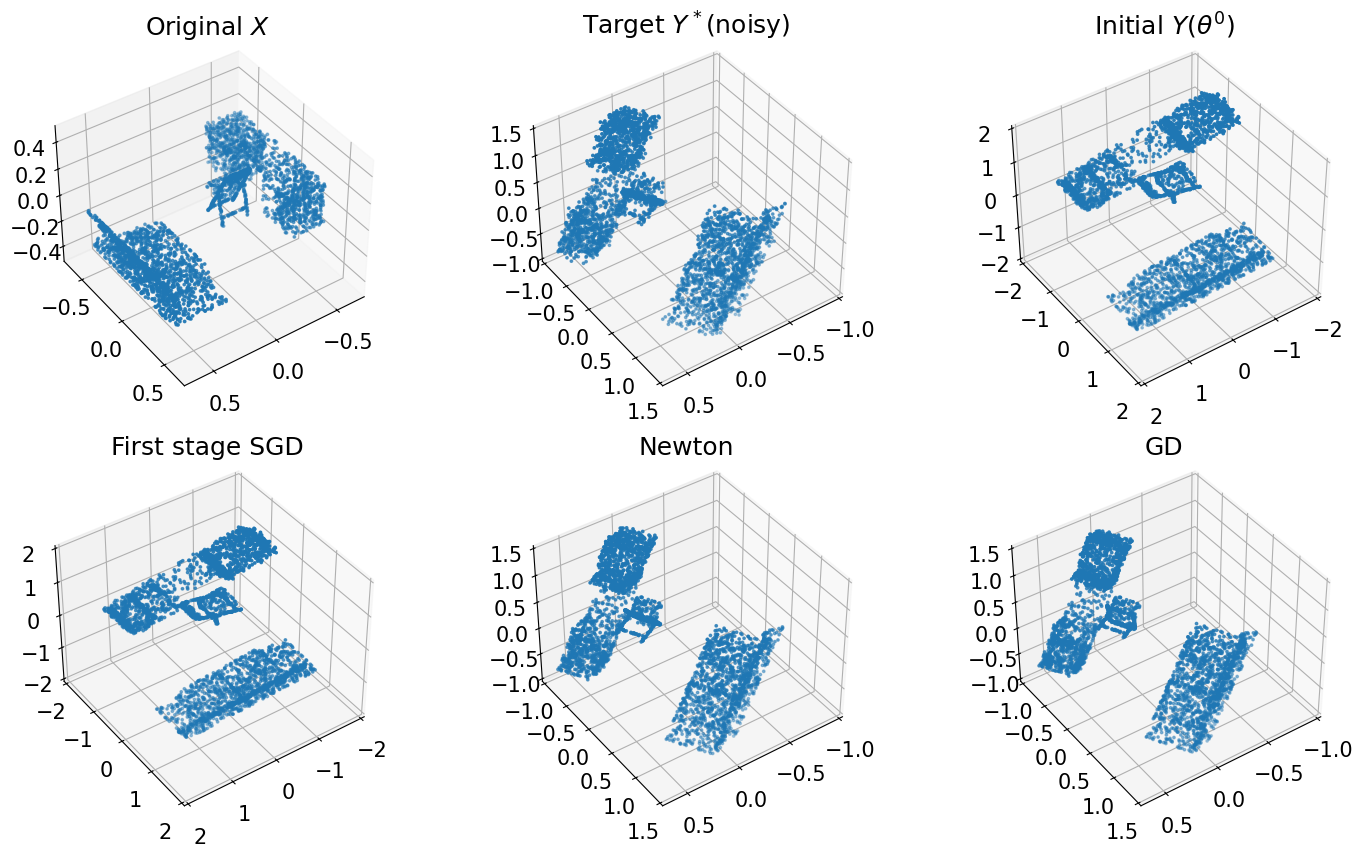

In [13]:


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

font = {'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)
fig = plt.figure()
fig.set_size_inches(18, 10)

spec = matplotlib.gridspec.GridSpec(ncols=6, nrows=2) # 6 columns evenly divides both 2 & 3

ax1 = fig.add_subplot(spec[0,0:2],projection='3d') # row 0 with axes spanning 2 cols on evens
ax2 = fig.add_subplot(spec[0,2:4],projection='3d')
ax3 = fig.add_subplot(spec[0,4:],projection='3d')
ax4 = fig.add_subplot(spec[1,0:2],projection='3d') # row 0 with axes spanning 2 cols on evens
ax5 = fig.add_subplot(spec[1,2:4],projection='3d')
ax6 = fig.add_subplot(spec[1,4:],projection='3d')



ax1.scatter(norm_pointcloud[:,0], norm_pointcloud[:,1], norm_pointcloud[:,2], s=3)
ax1.set_xlim([-0.7,0.7])
ax1.set_ylim([-0.7,0.7])
ax1.set_zlim([-0.5, 0.5])
ax1.set_box_aspect([1.0, 1.0, 0.8])
ax1.set_title("Original $X$")

ax1.view_init(elev=40, azim=55, roll=0)
#ax1.set_box_aspect([1.0, 1.0, 0.5])


ax2.scatter(noisy_rot_pointcloud_permute[:,0], noisy_rot_pointcloud_permute[:,1], noisy_rot_pointcloud_permute[:,2], s=3)
ax2.set_xlim([-1,0.7])
ax2.set_ylim([-1,1.5])
ax2.set_zlim([-1, 1.5])
ax2.set_box_aspect([1.0, 1.0, 0.8])
ax2.set_title(r"Target $Y^*$(noisy)" )
ax2.view_init(elev=40, azim=55, roll=0)



y_target_sgd_int         = x_jx @ sgd_params[0]
y_target_sgd         = x_jx @ newton_params_ana[0]
y_target_newton      = x_jx @ newton_params_ana[-1]
y_target_gd         = x_jx @ sgd_params_new[-1]


ax3.scatter(y_target_sgd_int[:,0], y_target_sgd_int[:,1], y_target_sgd_int[:,2], s=3)
ax3.set_xlim([-2,2])
ax3.set_ylim([-2,2])
ax3.set_zlim([-2, 2])
ax3.set_box_aspect([1.0, 1.0, 0.8])
ax3.set_title(r"Initial $Y(\theta^{0})$")
ax3.view_init(elev=40, azim=55, roll=0)


ax4.scatter(y_target_sgd[:,0], y_target_sgd[:,1], y_target_sgd[:,2], s=3)
ax4.set_xlim([-2,2])
ax4.set_ylim([-2,2])
ax4.set_zlim([-2, 2])
ax4.set_box_aspect([1.0, 1.0, 0.8])
ax4.set_title(r"First stage SGD")
ax4.view_init(elev=40, azim=55, roll=0)

ax5.scatter(y_target_newton[:,0], y_target_newton[:,1], y_target_newton[:,2], s=3)
ax5.set_xlim([-1,0.7])
ax5.set_ylim([-1,1.5])
ax5.set_zlim([-1, 1.5])
ax5.set_box_aspect([1.0, 1.0, 0.8])
ax5.set_title(r"Newton")
ax5.view_init(elev=40, azim=55, roll=0)



ax6.scatter(y_target_gd[:,0], y_target_gd[:,1], y_target_gd[:,2], s=3)
ax6.set_xlim([-1,0.7])
ax6.set_ylim([-1,1.5])
ax6.set_zlim([-1, 1.5])
ax6.set_box_aspect([1.0, 1.0, 0.8])
ax6.set_title(r"GD")
ax6.view_init(elev=40, azim=55, roll=0)

plt.savefig("3d_pointcloud_result.pdf", format="pdf", bbox_inches="tight")


In [14]:
sgd_params[0]

Array([[-1.24108414,  0.7901129 , -2.89769388],
       [ 2.08306837, -1.95086224, -3.05632896],
       [-0.45380753, -2.04743094, -1.42681683]], dtype=float64)

In [15]:
sgd_params[-1]

Array([[-1.21002495,  0.87555997, -2.37590712],
       [ 1.98149803, -1.81041558, -2.8218879 ],
       [-0.45444307, -2.04268656, -1.45743184]], dtype=float64)

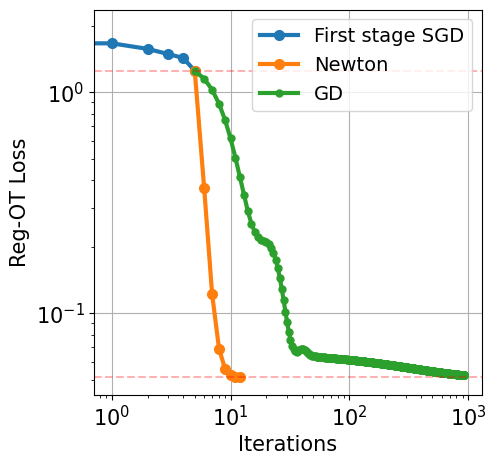

In [16]:
import matplotlib

font = {'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

fig = plt.figure()
fig.set_size_inches(5, 5)
ax1 = fig.add_subplot()
plt.plot(np.arange(len(sgd_loss)), sgd_loss,label='First stage SGD',marker='o',lw=3,markersize=7)
plt.plot(np.arange(len(sgd_params)-1, len(sgd_params)-1+len(newton_loss_ana)),newton_loss_ana,lw=3,marker='o', markersize=7, label='Newton')
plt.plot(np.arange(len(sgd_params)-1, len(sgd_params)-1+len(sgd_loss_new)), sgd_loss_new, lw=3,marker='o',markersize=5,label ='GD')

plt.axhline(y =newton_loss_ana[-1] , color = 'r', alpha=0.3,linestyle = '--') 
plt.axhline(y =sgd_loss[len(sgd_params)-1] , color = 'r', alpha=0.3,linestyle = '--') 

ax1.set_xticks([len(sgd_params)-1, len(sgd_loss_new)+len(sgd_params)-1])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.yticks([0.1, 0.5])
#ax1.set_yticks([0.5, newton_loss_ana[-1],sgd_loss[len(sgd_params)-1],sgd_loss[1]])
#ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Reg-OT Loss')
ax1.set_title('')
ax1.grid()
ax1.legend(fontsize=14)


    

plt.savefig("3d_pointcloud_OT_loss.pdf", format="pdf", bbox_inches="tight")


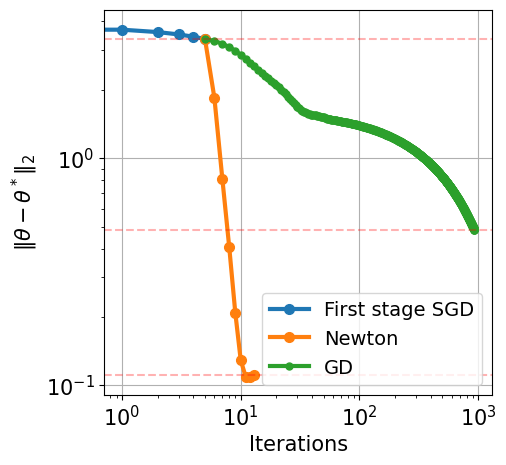

In [17]:

error_sgd = []
error_newton = []
error_gd = []
for i in range(len(sgd_params)):
    error_sgd.append(jnp.linalg.norm(sgd_params[i]-matrix))
    
for i in range(len(newton_params_ana)):
    error_newton.append(jnp.linalg.norm(newton_params_ana[i]-matrix))

for i in range(len(sgd_params_new)):
    error_gd.append(jnp.linalg.norm(sgd_params_new[i]-matrix))
fig = plt.figure()
fig.set_size_inches(5, 5)    
ax2 = fig.add_subplot()

ax2.plot(np.arange(len(sgd_loss)), error_sgd,label='First stage SGD',marker='o',lw=3,markersize=7)
ax2.plot(np.arange(len(sgd_params)-1, len(sgd_params)-1+len(newton_params_ana)), error_newton,label='Newton',marker='o',lw=3,markersize=7)
ax2.plot(np.arange(len(sgd_params)-1, len(sgd_params)-1+len(sgd_params_new)), error_gd, label ='GD',marker='o',lw=3,markersize=5)

ax2.axhline(y =error_newton[-1] , color = 'r', alpha=0.3,linestyle = '--') 
ax2.axhline(y =error_sgd[-1] , color = 'r', alpha=0.3,linestyle = '--') 
ax2.axhline(y =error_gd[-1] , color = 'r', alpha=0.3,linestyle = '--') 

#ax2.set_xticks([len(sgd_params)-1, len(sgd_loss_new)+len(sgd_params)-1])
#ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax2.set_yticks([error_newton[-1],error_sgd[-1],error_gd[-1]])
#ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_yscale('log')
ax2.set_xscale('log')

ax2.set_xlabel('Iterations')
ax2.set_ylabel(r'$\|\theta-\theta^*\|_2$')
ax2.grid()
ax2.legend(fontsize=14)
plt.savefig("3d_pointcloud_error.pdf", format="pdf", bbox_inches="tight")
